# Deep Neural Network Gesture Classifier

## Static gestures classification using Convolutional Neural Networks on the example of the Russian Sign Language (RSL) dactyl.

The project demonstrates the system of classification of static gestures of RSL, which is based on the approach of computer vision using convolutional neural network. The work is actual and represents a starting point for researchers in the field of gesture recognition.


In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Helpers

In [2]:
from random import randint

# Plot row (1x5) of images with titles
def plot_row_5(pics, titles):
    plt.figure(figsize=(10, 3))
    for i in range(0, 5):
        plt.subplot(1, 5, i + 1)
        plt.title(titles[i], wrap=True)
        plt.imshow(pics[i], cmap='gray')
    plt.tight_layout()
    plt.show()
    
# Plot 2x5
def plot_2_5(X_data, labels_count, np_classes):
    l_bound = 0
    r_bound = 0
    class_counter = 0

    for row in range(2):
        pics_to_print = []
        titles_to_print = []
        for col in range(5):
            r_bound += labels_count[class_counter]
            index = randint(l_bound, r_bound - 1)
            pics_to_print.append(X_data[index])
            titles_to_print.append("Class: {0} \n Value: {1} \n Quantity: {2}".format(
                np_classes[class_counter][0],
                np_classes[class_counter][1],
                labels_count[class_counter]))
            l_bound += labels_count[class_counter]
            class_counter += 1
        plot_row_5(pics_to_print, titles_to_print)

In [3]:
# Extract features from a list of images
def prepare_dataset(paths, labels, color_space='RGB'):
    images = []
    for path in paths:
        # Read in each image one by one
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        #img = mpimg.imread(path)
        
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
                # hand segmentation
                skin_ycrcb_mint = np.array((0, 133, 77))
                skin_ycrcb_maxt = np.array((255, 173, 127))
                image = cv2.inRange(image, skin_ycrcb_mint, skin_ycrcb_maxt)
            elif color_space == 'Gray':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            image = img
        images.extend([image])
    
    X_data = np.array(images)
    if color_space == 'Gray':
        X_data = np.reshape(X_data, (-1, 128, 128, 1))
    y_data = np.array(labels)
    
    return X_data, y_data

## 2. Dataset

The dataset for learning, validating and testing a neural network consists of around 1000 images with a resolution of 128x128 pixels.
The image is divided into 10 classes, each of which corresponds to a strictly defined gesture.


In [4]:
# How many unique classes/labels there are in the dataset
classes_file = 'gestnames.csv'

with open(classes_file, mode = 'rb') as f:
    # Read csv to pandas dataframe
    df_classes = pd.read_csv(f)
    # Convert pandas dataframe to numpy array
    np_classes = df_classes.as_matrix()

num_of_classes = np_classes.shape[0]
print ("Number of unique classes: {0}".format(num_of_classes))

Number of unique classes: 10


Loading dataset...
(1042, 128, 128)
(1042,)
Loading completed


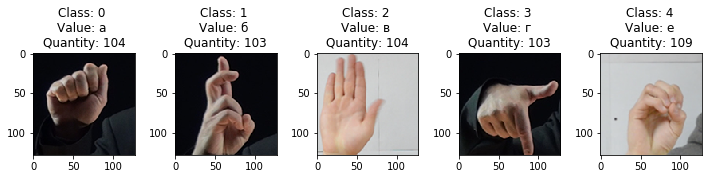

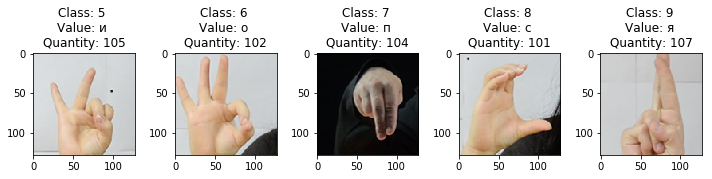

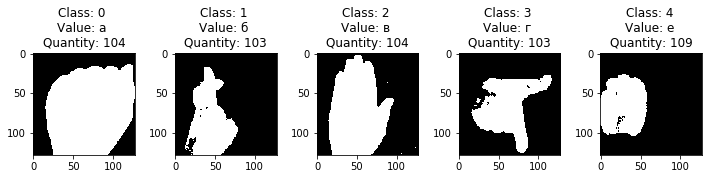

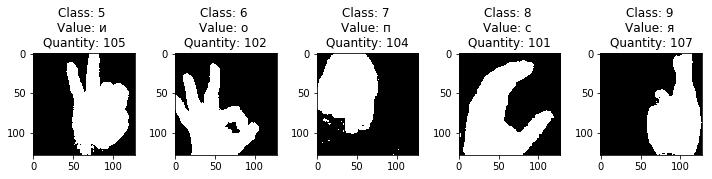

In [5]:
import glob

# Read the images and assigned them to classes
paths = []
labels = []
labels_count = []

print ("Loading dataset...")
for i in range(num_of_classes):
    path = 'hand/' + str(i) + '/*.png'
    gest_class = glob.glob(path, recursive=True)
    # append new labels
    labels += len(gest_class) * [i]
    # count num of label occurences
    labels_count.append(len(gest_class))
    # append instances of gesture class
    paths += gest_class

X_data_rgb, y_data_rgb = prepare_dataset(paths, labels, color_space='RGB')
X_data, y_data = prepare_dataset(paths, labels, color_space='YCrCb')
print (X_data.shape)
print (y_data.shape)

print ("Loading completed")

# Plot Examples
plot_2_5(X_data_rgb, labels_count, np_classes)
plot_2_5(X_data, labels_count, np_classes)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# !!!!!!!!!
X_data = np.reshape(X_data, (-1, 128, 128, 1))
# !!!!!!!!!
# Shuffle the data
X_data, y_data = shuffle(X_data, y_data)

# Train, Validation and Test split of dataset:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1)

print ("Training set: {0}".format(X_train.shape[0]))
print ("Cross-validation set: {0}".format(X_val.shape[0]))
print ("Test set: {0}".format(X_test.shape[0]))

Training set: 666
Cross-validation set: 167
Test set: 209


In [7]:
# Build the basic neural network to verify that everything is working
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [8]:
batch_size = 128
num_classes = num_of_classes
epochs = 24

# Convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_val = np_utils.to_categorical(y_val, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

print ("The shape of the data:")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

The shape of the data:
(666, 128, 128, 1)
(666, 10)
(167, 128, 128, 1)
(167, 10)
(209, 128, 128, 1)
(209, 10)


## 3. CNN Model Architecture

In [9]:
model = Sequential()
# Pixel normalization:
# pixel_normalized = pixel / 255
# pixel_mean_centered = pixel_normalized - 0.5
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (128, 128, 1)))
model.add(Convolution2D(8, 5, 5, subsample = (2, 2), activation = "relu"))
model.add(Convolution2D(24, 5, 5, subsample = (2, 2), activation = "relu"))
model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = "relu"))
model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = "relu"))
#model.add(Convolution2D(64, 3, 3, activation = "relu"))
model.add(Convolution2D(64, 3, 3, activation = "relu"))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dense(num_classes, activation='softmax'))

The final model architecture consisted of a convolutional neural network with the following layers and layer sizes:

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 128, 128, 1)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 62, 62, 8)     208         lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 29, 29, 24)    4824        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 13, 13, 36)    21636       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
history_object = model.fit(X_train, 
                           y_train,
                           batch_size      = batch_size,
                           nb_epoch        = epochs,
                           verbose         = 1,
                           validation_data = (X_val, y_val))

Train on 666 samples, validate on 167 samples
Epoch 1/24
666/666 [==============================] - 4s - loss: 2.2249 - acc: 0.1742 - val_loss: 1.9989 - val_acc: 0.2874
Epoch 2/24
666/666 [==============================] - 3s - loss: 1.7193 - acc: 0.4159 - val_loss: 1.6823 - val_acc: 0.3892
Epoch 3/24
666/666 [==============================] - 3s - loss: 1.3924 - acc: 0.4955 - val_loss: 1.2527 - val_acc: 0.5329
Epoch 4/24
666/666 [==============================] - 3s - loss: 1.0893 - acc: 0.6261 - val_loss: 0.9407 - val_acc: 0.7066
Epoch 5/24
666/666 [==============================] - 3s - loss: 0.8113 - acc: 0.7027 - val_loss: 0.9426 - val_acc: 0.6587
Epoch 6/24
666/666 [==============================] - 3s - loss: 0.6828 - acc: 0.7508 - val_loss: 0.6525 - val_acc: 0.7545
Epoch 7/24
666/666 [==============================] - 3s - loss: 0.5629 - acc: 0.8033 - val_loss: 0.4245 - val_acc: 0.8623
Epoch 8/24
666/666 [==============================] - 3s - loss: 0.3952 - acc: 0.8529 - val_l

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


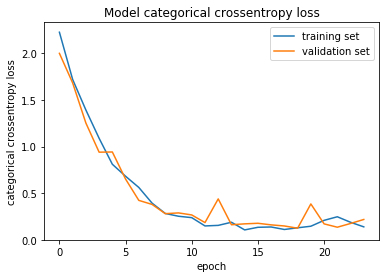

In [13]:
# Print the keys contained in the history object
print(history_object.history.keys())

# Plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model categorical crossentropy loss')
plt.ylabel('categorical crossentropy loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig('loss_graph.png', bbox_inches='tight')

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.238594918445
Test accuracy: 0.913875598657


In [15]:
# creates a HDF5 file 'my_model.h5'
#model.save('LAST__my_model.h5')

In [16]:
# Probabilities for Test dataset
test_predict_acc = model.predict(X_test, batch_size=32, verbose=0)

## 4. Experiment

Evaluate the data that never been in the dataset.

Loading experimental dataset...


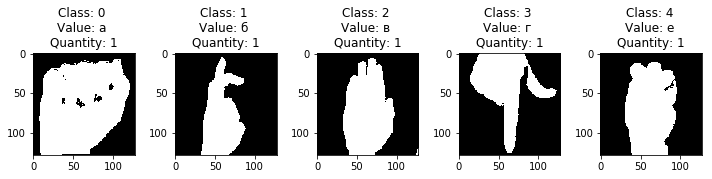

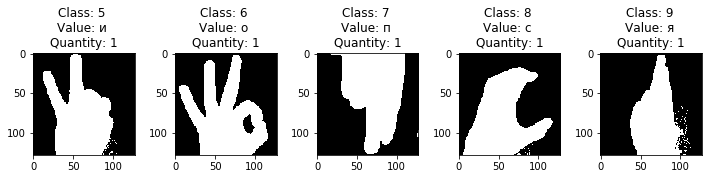

Loading completed
Experimental data shape:
(10, 128, 128, 1)
[0 1 2 3 4 5 6 7 8 9]


In [20]:
# Load Experimental data

exp_paths = []
exp_labels = []
exp_labels_count = []

print ("Loading experimental dataset...")
for i in range(num_of_classes):
    path = 'hand/experiment/' + str(i) + '/*.png'
    gest_class = glob.glob(path, recursive=True)
    # append new labels
    exp_labels += len(gest_class) * [i]
    # count num of label occurences
    exp_labels_count.append(len(gest_class))
    # append instances of gesture class
    exp_paths += gest_class

X_exp_data, y_exp_data = prepare_dataset(exp_paths, exp_labels, color_space='YCrCb')

# Print Experimental pics
class_counter = 0

for row in range(2):
    pics_to_print = []
    titles_to_print = []
    for col in range(5):
        index = class_counter
        pics_to_print.append(X_exp_data[index])
        titles_to_print.append("Class: {0} \n Value: {1} \n Quantity: {2}".format(
            np_classes[class_counter][0],
            np_classes[class_counter][1],
            exp_labels_count[class_counter]))
        class_counter += 1
    plot_row_5(pics_to_print, titles_to_print)

print ("Loading completed")

# !!!!!!!!!
X_exp_data = np.reshape(X_exp_data, (-1, 128, 128, 1))
# !!!!!!!!!
print ("Experimental data shape:")
print (X_exp_data.shape)
print (y_exp_data)

In [18]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Probabilities for Experimental dataset
exp_predict_acc = model.predict(X_exp_data, batch_size=32, verbose=0)
print (exp_predict_acc)

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.998  0.     0.     0.     0.     0.     0.     0.     0.001]
 [ 0.     0.002  0.998  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.195  0.     0.021  0.     0.     0.783  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.94   0.06   0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     1.     0.   ]
 [ 0.     0.003  0.     0.     0.     0.     0.     0.     0.     0.997]]


In [ ]:
from matplotlib import pyplot as plt

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

print("{}".format(exp_predict_acc[0]))
print(y_exp_data[0])
data = X_exp_data[0]
plt.figure(figsize=(1, 1))
plt.imshow(data, interpolation='nearest')
plt.show()
print("--------------------")

print("{}".format(exp_predict_acc[1]))
print(y_exp_data[1])
data = X_exp_data[1]
plt.figure(figsize=(1, 1))
plt.imshow(data, interpolation='nearest')
plt.show()
print("--------------------")
